<a href="https://colab.research.google.com/github/AyoubMotei/energy-demand-forecasting-lstm/blob/master/Pr%C3%A9vision_De_La_Demande_%C3%89nerg%C3%A9tique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Prévision de la Demande Énergétique pour Smart Grid via LSTM***

**0. Chargement du dataset**

In [4]:
df = pd.read_csv("dataset.csv")
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


**1. Préparation des données temporelles**

In [5]:
import pandas as pd


# Conversion en format Date
df["DateTime"] = pd.to_datetime(df["DateTime"])

# Tri chronologique
df = df.sort_values("DateTime")

# Définir le temps comme index pour faciliter les graphiques
df.set_index("DateTime", inplace=True)

-Pourquoi l’ordre temporel est critique?<br>
L’ordre temporel est critique car chaque observation dépend des précédentes. Le LSTM apprend des séquences chronologiques ; si l’ordre est modifié, le modèle ne peut plus comprendre les cycles de consommation ni les pics journaliers.<br><br>
-Pourquoi on ne mélange pas les données (pas de shuffle)?<br>
On ne mélange pas les données car cela provoquerait une fuite de données temporelles. Le modèle verrait le futur lors de l’entraînement, ce qui fausserait totalement l’évaluation et rendrait le modèle inutilisable en conditions réelles.


**2. Normalisation des données**

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

-Pourquoi la normalisation est indispensable en Deep Learning? <br>
La normalisation est indispensable en Deep Learning car elle met toutes les variables sur la même échelle, stabilise l’apprentissage, accélère la convergence et évite qu’une variable domine artificiellement les autres.<br><br>

-Pourquoi MinMax est souvent préféré à StandardScaler pour LSTM? <br>

MinMaxScaler est souvent préféré pour les LSTM car il borne les données dans des intervalles compatibles avec les fonctions d’activation tanh et sigmoid, ce qui stabilise l’apprentissage et améliore la convergence.

**3. Création des séquences (Windowing)**

In [10]:
import numpy as np




NameError: name 'scaleddata' is not defined

In [12]:
def create_sequences(data, window=24):
  X, y = [], []
  for i in range(window, len(data)):
    # X : Les 24 heures précédentes (toutes les colonnes)
    X.append(data[i-window:i])
    # y : La consommation à l'heure actuelle (colonne 0)
    y.append(data[i, 0]) # Consumption
  return np.array(X), np.array(y)


X, y = create_sequences(scaled_data, window=24)

-Pourquoi un LSTM attend des données en 3D? <br>
Un LSTM attend des données en 3D car il traite des séquences temporelles, et chaque prédiction dépend de plusieurs instants passés, pas d’une seule observation.<br><br>

-Signification de la forme : (samples, timesteps, features)?<br>

samples : nombre d’exemples

timesteps : dimension temporelle ( 24 heures )

features : informations disponibles à chaque heure (consommation + productions énergétiques)


**4. Split Train / Test (temporel)**

In [13]:
split = int(0.8 * len(X))
Xtrain, Xtest = X[:split], X[split:]
ytrain, ytest = y[:split], y[split:]

Pourquoi on ne fait pas de traintestsplit classique ?<br>

On n’utilise pas de train_test_split classique en série temporelle car il mélange les données et introduit une fuite temporelle : le modèle pourrait apprendre à partir d’informations futures, ce qui invalide complètement l’évaluation

**5. Architecture LSTM**


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential([
    LSTM(64, input_shape=(24, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer="adam",
    loss="mse"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


-Impact du nombre d’unités LSTM :<br>
Le nombre d’unités LSTM contrôle la capacité de mémoire du modèle : trop peu entraîne un sous-apprentissage, trop entraîne un surapprentissage. Dans ce projet, 64 unités offrent un bon compromis entre performance et généralisation.<br><br>

-Différence entre 1 ou plusieurs couches LSTM : <br>
Une seule couche LSTM permet de capter les dépendances temporelles principales. Plusieurs couches augmentent la capacité du modèle en apprenant des abstractions plus complexes, mais au prix d’un risque accru de surapprentissage.

**6. Entrainement & Monitoring**


In [15]:
history = model.fit(
    Xtrain, ytrain,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0210 - val_loss: 0.0018
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0022 - val_loss: 7.9238e-04
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0017 - val_loss: 6.7387e-04
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0012 - val_loss: 5.8312e-04
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 9.8259e-04 - val_loss: 6.6308e-04
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 8.6281e-04 - val_loss: 4.5856e-04
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 7.6442e-04 - val_loss: 4.7402e-04
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 7.1496e-04 - val_loss: 4.5894e-04
Epoch 10/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 6.5880e-04 - val_loss: 4.1761e-04
Epoch 11/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 

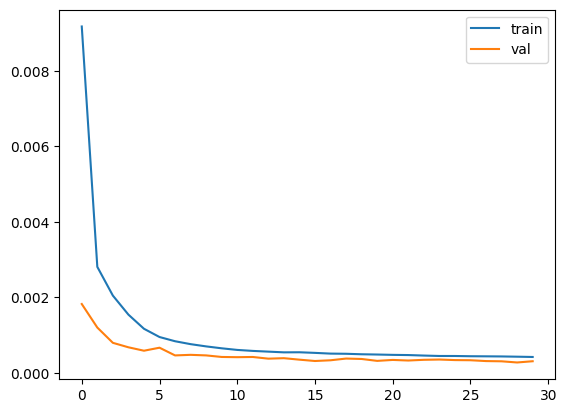

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


-Courbe loss vs val_loss :<br>
Le modèle améliore ses performances aussi bien sur le jeu d’entraînement que sur le jeu de validation.<br><br>

-Détection du surapprentissage: <br>
Les courbes loss et val_loss diminuent de manière parallèle et restent très proches tout au long de l’entraînement. Cela indique que le modèle apprend correctement sans surapprentissage. L’absence de remontée de la val_loss confirme une bonne capacité de généralisation sur les données temporelles.

**7. Evaluation du modèle**

339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


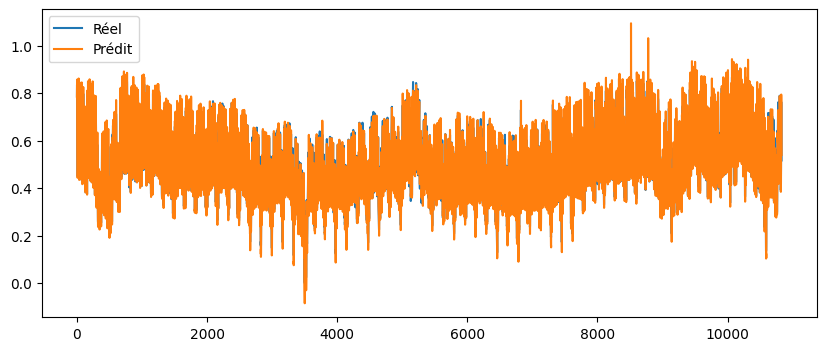

In [26]:
y_pred = model.predict(Xtest)

plt.figure(figsize=(10,4))
plt.plot(ytest, label="Réel")
plt.plot(y_pred, label="Prédit")
plt.legend()
plt.show()


Le graphe Réel vs Prédit montre une forte superposition des courbes, ce qui indique que le LSTM capture correctement les dépendances temporelles et les cycles de consommation. Les écarts observés concernent principalement des pics extrêmes, ce qui est cohérent avec le comportement attendu d’un modèle basé sur des patterns historiques.